In [1]:
from setup import InsightEnvironment
from gooddata_pandas import GoodPandas

# notebook input from an insight
env = InsightEnvironment("2b4589c0-8df1-4884-ab8c-5996b0a91581")

In [2]:
# setup
gp = GoodPandas(host=env.host, token=env.token)

In [3]:
# get the insight
insight = gp.sdk.insights.get_insight(env.workspace_id, env.insight_id)

In [4]:
# get the insight data in a data frame
df = gp.data_frames(env.workspace_id).for_insight(env.insight_id)

In [5]:
# summarize the data
df.describe()

,avg_temperature
count,1308.000000
mean,69.812653
std,3.041904
min,61.360000
25%,67.487500
50%,70.000000
75%,72.240000
max,76.570000


<Axes: xlabel='TIMESTAMP.hour'>

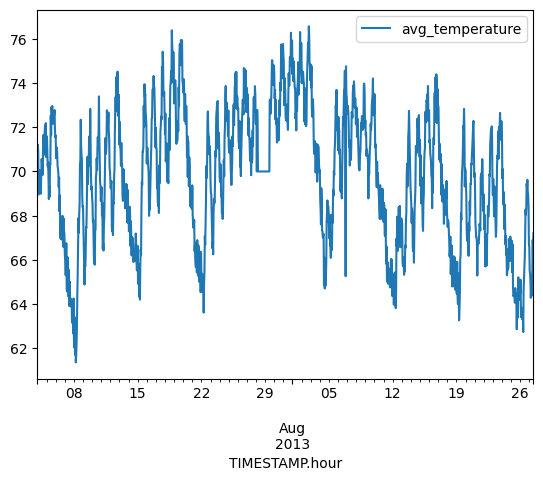

In [6]:
# visualise in a trend line (TODO probably delete)
df.plot()

The following forecasting model was created using the steps described here
https://cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html

Train dates : 2013-07-04 00:00:00 --- 2013-08-22 00:00:00  (n=1177)
Test dates  : 2013-08-22 01:00:00 --- 2013-08-27 11:00:00  (n=131)


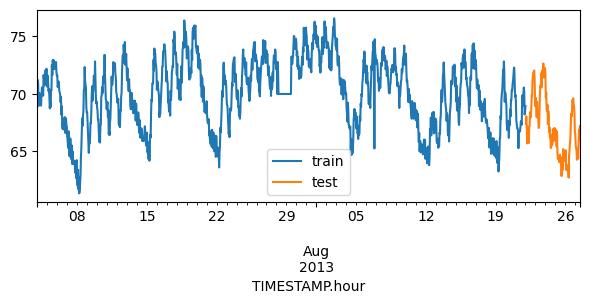

In [7]:
# split data into train and test data
import matplotlib.pyplot as plt

# set data frequency (i.e. hourly, monthly etc.)
# TODO fill by granularity
df = df.asfreq('H')

# number of steps we will try to predict
steps = round(len(df) * 0.1)
data_train = df[:-steps]
data_test = df[-steps:]
dim_y = df.columns.values[0]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax = plt.subplots(figsize=(7, 2.5))
data_train[dim_y].plot(ax=ax, label='train')
data_test[dim_y].plot(ax=ax, label='test')
ax.legend();

In [8]:
# train a forecasting model
from sklearn.ensemble import RandomForestRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg

# seed for reproducible results
seed = 123
# number of periods to use as a predictor for the next one
lags = 168
forecaster = ForecasterAutoreg(
    regressor=RandomForestRegressor(random_state=seed),
    lags=lags,
)

forecaster.fit(y=data_train[dim_y])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168] 
Transformer for y: None 
Transformer for exog: None 
Window size: 168 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2013-07-04 00

In [9]:
# model validation
predictions = forecaster.predict(steps=steps)

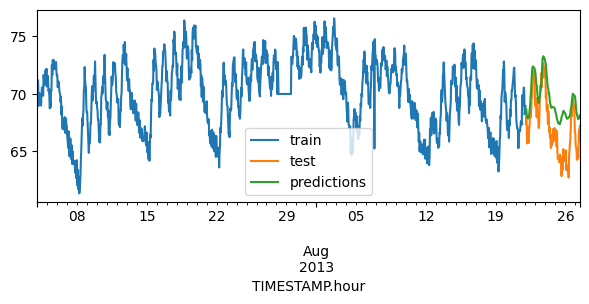

In [10]:
# plot predictions vs test data
fig, ax = plt.subplots(figsize=(7, 2.5))
data_train[dim_y].plot(ax=ax, label='train')
data_test[dim_y].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [11]:
# test error
from sklearn.metrics import mean_squared_error

error_mse = mean_squared_error(
    y_true = data_test[dim_y],
    y_pred = predictions
)

print(f"Test error (mse): {error_mse}")

Test error (mse): 6.650059369083968


In [12]:
# TODO hyper parameter tuning